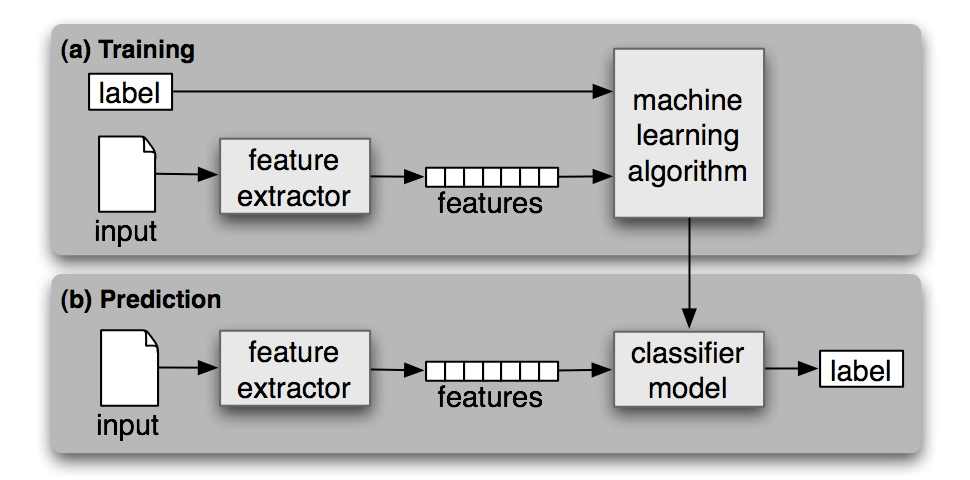

## Preprocessing

##### Clean and pre-process the dataset (text normalization)
1. make all reviews lowercase
2. remove all punctuations
3. remove stopwords (words with little meaning such as 'is','that')
4. apply lemmatisation, which turns a family of words with the same meaning to a single word. e.g. "dogs" &rarr; "dog". 

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import spacy

#nltk.download('stopwords')
#nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
tokeniser = nltk.tokenize.WhitespaceTokenizer()


def pre_processing():
    ReviewsFile = pd.read_csv('Test.csv') #reads dataset
    nlp = spacy.blank('en')
    ReviewsFile['text'] = ReviewsFile['text'].astype(str).str.lower() #makes all reviews lowercase
    punct = "\n\r" + string.punctuation
    ReviewsFile['text'] = ReviewsFile['text'].str.translate(str.maketrans('', '', punct)) #removes all punctuation
    stop = stopwords.words('english')
    ReviewsFile['text'] = ReviewsFile['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # removes stopwords
    ReviewsFile['text'].apply(lemmatisation)  #lemmatisation : changing words with same meaning into one word
    return ReviewsFile



def lemmatisation(text):
    return [lemmatizer.lemmatize(w) for w in tokeniser.tokenize(text)]

ModuleNotFoundError: No module named 'nltk'

## Feature Extraction

Convert text data into numerical features using CountVectorizer. First perform tokenization, then record frequency for each word specific to a feature(positive or negative) found in the reviews. 
1 = positive review, 0 = negative review. 

In [ ]:
import numpy as np
import math
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

reviewsFile = pre_processing()
reviews = reviewsFile['text'].values
labels = reviewsFile['label'].values

def getVocabandFrequencies():
    vec = CountVectorizer(max_features = 10000) #10000 is amount of unique words, this is a random number I chose , will probably change later 
    docTermMatrix = vec.fit_transform(reviews)
    allWords = vec.get_feature_names_out() #gets list of  all words seen in reviews
    docTermMatrix = docTermMatrix.toarray()
    wordCounts = {} # dictionary for word and their frequency
    for k in range(2):
        wordCounts[k] = defaultdict(lambda: 0) # if word not seen, automatic value in dictionary is 0
    for i in range(docTermMatrix.shape[0]): #iterates through the rows of the 2D array
        currentLabel = labels[i]
        for j in range(len(allWords)):
            wordCounts[currentLabel][allWords[j]] += docTermMatrix[i][j] #increments wordcount for word with that label
    return allWords, wordCounts

laplace function that returns the log of the probability that a word is in a sentence

In [ ]:
from math import log

def laplace(wordFrequency, sumAllWordFrequencies, sizeAllWords):
    probability = (wordFrequency + 1) / (sumAllWordFrequencies + sizeAllWords)
    return log(probability)


splits data into training set(80%) and testing set(20%) to allow cross-validation.
(technically we need 3 sets, training, validation, and testing). A holdout dataset (test set) is needed for evaluating the models.

image source: https://www.nltk.org/book/ch06.html



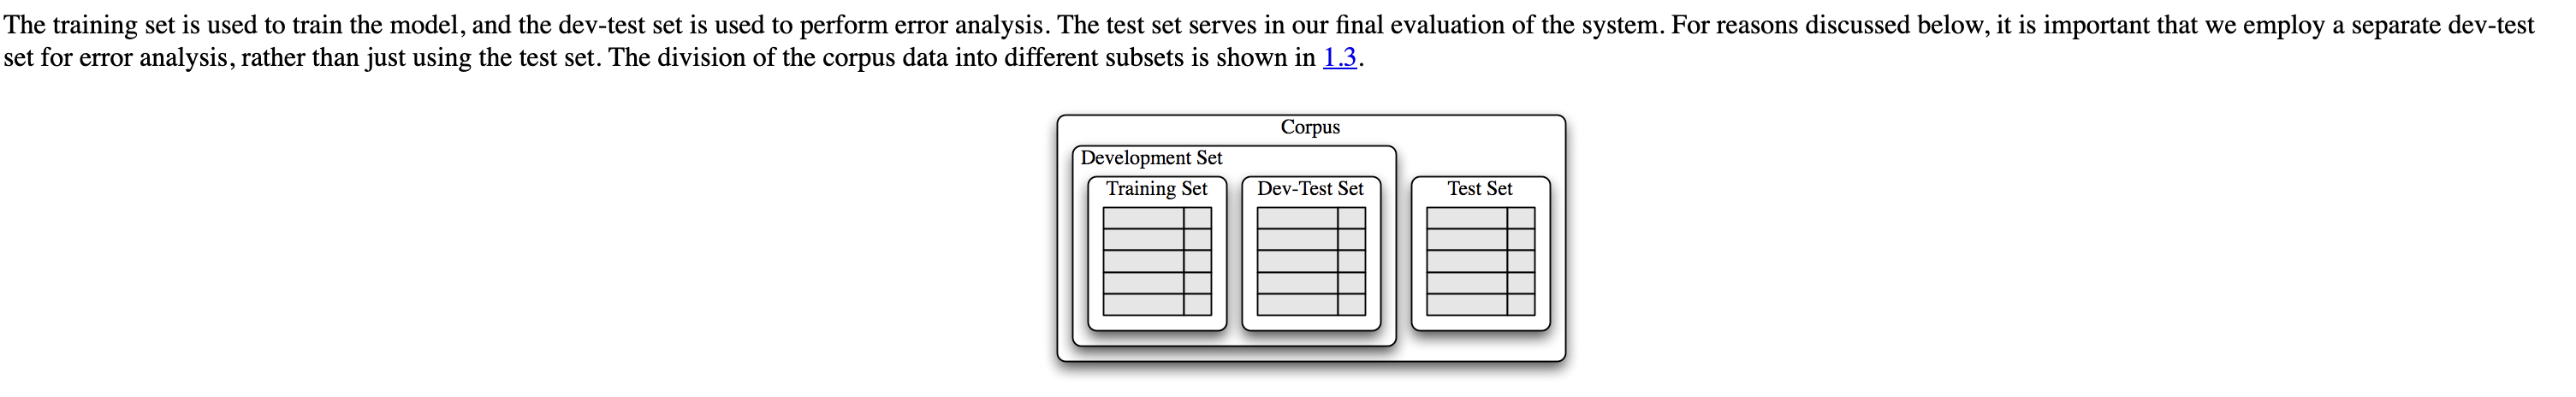

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


def split_data(csv_file_path, train_file_path, test_file_path, test_size=0.2, random_state=42):
    data = pd.read_csv(csv_file_path)
    
    #documentation on https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    # random_state controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    
    # split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
    test_data, validation_data = train_test_split(test_data, test_size=0.5, random_state=random_state)

    # show length
    len(train_data), len(test_data), len(validation_data)

    train_data.to_csv(train_file_path, index=False)
    test_data.to_csv(test_file_path, index=False)

prepare model, perform training

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(test_data) 

see the accuracy of the model based on test set.
also see what the most valuable words are when it comes to positive or negative reviews

In [ ]:
print('Accuracy: {:4.2f}'.format(nltk.classify.accuracy(classifier, test_data))) 
classifier.show_most_informative_features(15)

test using different classifiers from sklearn, perform training, and compare results:

In [ ]:
# documentation https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score# Naive Bayes Classifiers
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()# fitting and predicting

gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)# accuracy scores

print('Gaussian Accuracy: {:4.2f}'.formataccuracy_score(y_test, y_pred_gnb))
print('Multinomial Accuracy: {:4.2f}'.accuracy_score(y_test, y_pred_mnb))
print('Bernoulli Accuracy: {:4.2f}'.accuracy_score(y_test, y_pred_bnb))

# --print top 15 informative features here--
# --


# prints the top x most informative features
def print_topX(vectorizer, clf, class_labels, x):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        topX = np.argsort(clf.coef_[i])[-x:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in topX)))
        
# alternative method to print the top x most informative features
def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    print("Important words in negative reviews")

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print("-----------------------------------------")
    print("Important words in positive reviews")

    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)